<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Segmenting-and-Clustering-Neighborhood-in-Toronto" data-toc-modified-id="Segmenting-and-Clustering-Neighborhood-in-Toronto-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Segmenting and Clustering Neighborhood in Toronto</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Scrape-data-from-Wekipedia" data-toc-modified-id="Scrape-data-from-Wekipedia-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Scrape data from Wekipedia</a></span></li><li><span><a href="#Add-more-geospatial-information" data-toc-modified-id="Add-more-geospatial-information-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Add more geospatial information</a></span></li></ul></li><li><span><a href="#Neighborhood-Segementation" data-toc-modified-id="Neighborhood-Segementation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Neighborhood Segementation</a></span><ul class="toc-item"><li><span><a href="#Get-Venue-information-using-Foursquare-API" data-toc-modified-id="Get-Venue-information-using-Foursquare-API-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Get Venue information using Foursquare API</a></span></li><li><span><a href="#Generate-features-for-clustering" data-toc-modified-id="Generate-features-for-clustering-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Generate features for clustering</a></span></li><li><span><a href="#Apply-Elbow-method-to-determine-the-number-of-clusters" data-toc-modified-id="Apply-Elbow-method-to-determine-the-number-of-clusters-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Apply Elbow method to determine the number of clusters</a></span></li><li><span><a href="#Visualization-using-Folium" data-toc-modified-id="Visualization-using-Folium-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Visualization using Folium</a></span></li></ul></li></ul></li></ul></div>

# Segmenting and Clustering Neighborhood in Toronto 

## Data Preparation 

In [131]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans



### Scrape data from Wekipedia

In [42]:
# Get requests 
requests = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
neighborhood = BeautifulSoup(requests.text) 
tables = neighborhood.find_all("table")

# Convert to pandas table 
table = []
for row in tables[0].find_all("tr"): 
    row_data = [] 
    
    for cell in row.find_all("td"): 
        row_data.append(cell.text)
    
    if not row_data == []: 
        table.append(row_data)

data = pd.DataFrame(table, columns = ["PostalCode", "Borough", "Neighborhood"])

# Remove \n 
data = data.replace("\n","", regex=True)

# Remove observations where Borough = Not assigned
data = data[data.Borough != "Not assigned"]
data

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [43]:
print(f"- There are {data.shape[0]} rows in the dataframe")

- There are 103 rows in the dataframe


### Add more geospatial information

In [45]:
# Add coordinates 
coordinates = pd.read_csv("http://cocl.us/Geospatial_data")
data = pd.merge(data, coordinates, left_on="PostalCode", right_on="Postal Code", how="left").drop(columns=["Postal Code"])

In [48]:
data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [49]:
print('- The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(data['Borough'].unique()),
        data.shape[0]
    )
)

- The dataframe has 10 boroughs and 103 neighborhoods.


## Neighborhood Segementation
Here I'm going to segment all neighborhoods in Toronto. The frequency of venues in each neighborhood will be used as key features to cluster similar neighborhoods. Elbow method is used to deicde the number of clusters and Folium is used map each neighborhood point on the map.

In [55]:
# Get the latitude and longitude of Toronto 
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="trt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Get Venue information using Foursquare API 

In [61]:
# get top 100 venues that are in each neighborhoods within a radius of 500 meters
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
CLIENT_ID = "AA405KPT040BGEPDFRROHTRLTYDACBRK1DWXYQ0X5E4TVWLJ"
CLIENT_SECRET = "QO3DV3PDE0MUIFCODTOMPNUFHPDC4IXXYC0JXXDXCP2BGWSR"
VERSION = '20180605'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [63]:
toronto_venues = getNearbyVenues(names=data['Neighborhood'],
                                   latitudes=data['Latitude'],
                                   longitudes=data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [102]:
toronto_venues.rename(columns={"Neighborhood":"Neighborhoods"}, inplace=True)
toronto_venues

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
...,...,...,...,...,...,...,...
2132,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
2133,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Once Upon A Child,43.631075,-79.518290,Kids Store
2134,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Value Village,43.631269,-79.518238,Thrift / Vintage Store
2135,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Kingsway Boxing Club,43.627254,-79.526684,Gym


### Generate features for clustering 

In [106]:
# use one-hot encoding to Venue Category 
toronto_venues.rename(columns={"Neighborhood":"Neighborhoods"}, inplace=True)
ohe = OneHotEncoder(sparse=False, dtype=int)

toronto_oht = pd.concat((toronto_venues, pd.DataFrame(ohe.fit_transform(toronto_venues[["Venue Category"]]),
                           columns=ohe.categories_[0])),
          axis=1)
toronto_oht

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Accessories Store,Afghan Restaurant,Airport,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2133,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Once Upon A Child,43.631075,-79.518290,Kids Store,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2134,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Value Village,43.631269,-79.518238,Thrift / Vintage Store,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2135,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Kingsway Boxing Club,43.627254,-79.526684,Gym,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_oht.groupby('Neighborhoods').mean().reset_index()
toronto_grouped 

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,43.794200,-79.262029,43.792613,-79.261140,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",43.602414,-79.543484,43.601800,-79.544687,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,43.755657,-79.440379,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,43.786947,-79.385975,43.787903,-79.380860,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",43.733282,-79.419750,43.733831,-79.419433,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale East",43.770120,-79.408493,43.768706,-79.412752,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0
92,"Willowdale, Willowdale West",43.782736,-79.442259,43.783574,-79.445919,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
93,Woburn,43.770992,-79.216917,43.771113,-79.220309,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
94,Woodbine Heights,43.695344,-79.318389,43.696405,-79.315029,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


### Apply Elbow method to determine the number of clusters

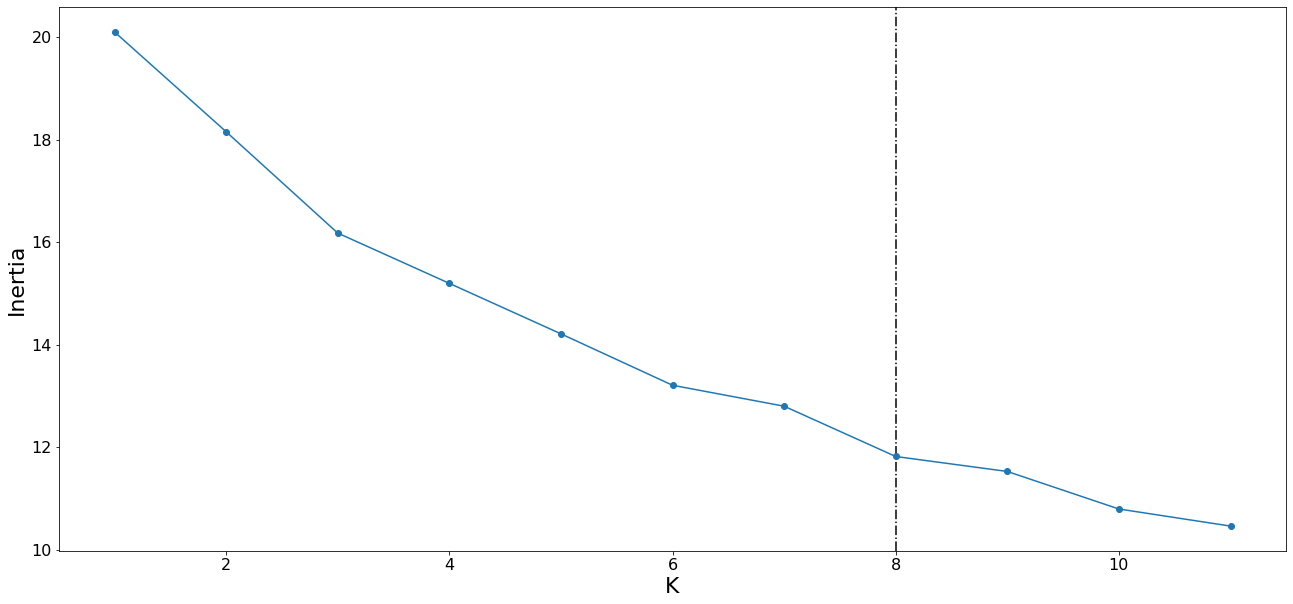

In [127]:
# Cluster neighborhood 
toronto_grouped_clustering = toronto_grouped.drop(columns=['Neighborhoods', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue Latitude', 'Venue Longitude'])


# Use elbow methods to decide k
kmeans = list()
for k in range(1,12):
    kmeans.append(KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering))
    
    
def plot_elbow(w, h, kmeans):
    plt.figure(figsize = (w,h))
    plt.axvline(x=8, linestyle='-.', c="black")
    plt.plot(range(1,12),[k.inertia_ for k in kmeans], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)
    
plot_elbow(22,10, kmeans)

- Given the Elbow plot, I'll use cluster neighborhoods in 8 clusters.

In [128]:
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)


In [129]:
toronto_grouped

,Cluster Labels,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1,Agincourt,43.794200,-79.262029,43.792613,-79.261140,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0,"Alderwood, Long Branch",43.602414,-79.543484,43.601800,-79.544687,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,43.755657,-79.440379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Bayview Village,43.786947,-79.385975,43.787903,-79.380860,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1,"Bedford Park, Lawrence Manor East",43.733282,-79.419750,43.733831,-79.419433,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,"Willowdale, Willowdale East",43.770120,-79.408493,43.768706,-79.412752,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0
92,1,"Willowdale, Willowdale West",43.782736,-79.442259,43.783574,-79.445919,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
93,1,Woburn,43.770992,-79.216917,43.771113,-79.220309,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
94,6,Woodbine Heights,43.695344,-79.318389,43.696405,-79.315029,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


### Visualization using Folium 

In [133]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_grouped['Neighborhood Latitude'], toronto_grouped['Neighborhood Longitude'], toronto_grouped['Neighborhoods'], toronto_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('./toronto_neighborhood_clustering.html')

In [134]:
from IPython.display import HTML
HTML('<iframe src=toronto_neighborhood_clustering.html width=700 height=450></iframe>')


/Users/haoyusu/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
